In [2]:
# Import the necessary libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn import preprocessing 
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# Use BigQuery to store and read the data.

QUERYS IN SQL BIGQUERY:
#MUNICIPIO
 https://console.cloud.google.com/bigquery?sq=995144496134:4ddf9e19dd4f47cfa50b1337469b6ab1
#ZONA
 https://console.cloud.google.com/bigquery?sq=995144496134:b04a6259a4254e119c93deda1fbc9af4
#ESCOLARIDAD
 https://console.cloud.google.com/bigquery?sq=995144496134:1a220798dbb441969f7ba412d99fdd87


# What data quality issues do you evidence? How could you solve them? Write some querys in SQL to explore the data in Bigquery.

The biggest issues of the querys where the labels of the columns names, some of them had accent marks and bar spaces that make difficult to access to the dataset. This problem can be solved by replacing this labels before import the data.

# Explore the data and answer these questions using Pandas or Koalas, Matplotlib or Potly to find more insights.

What were the top municipalities with highest quantity of murders by month?

In [4]:
df = pd.read_csv("homicidios-2018.csv",sep = ";")
df["Fecha"] = pd.to_datetime(df["Fecha"])
df = df.drop(df.shape[0]-1)
df["Municipio"] = df["Municipio"].replace(" \(CT\)","",regex = True)

The top  three municipalities with highest quantity of murders are: 
 Cali, Bogotá D.C. and Medellin no matter the time of the year


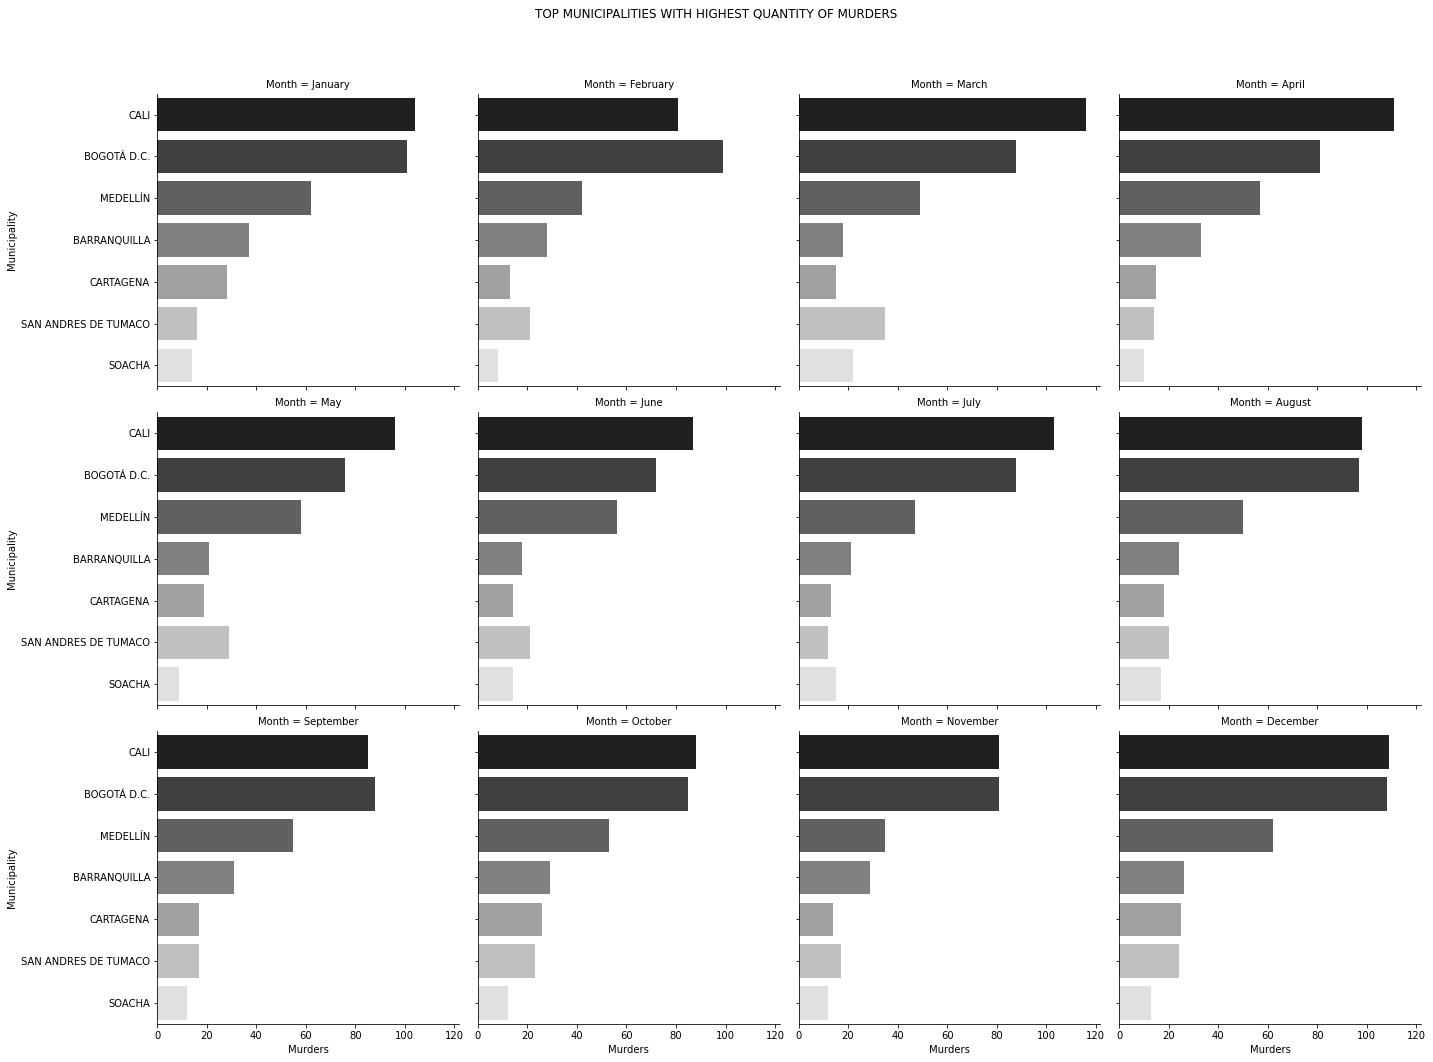

In [5]:
#Municipalities with highest quantity of murders by month
monthMun = df[["Fecha","Municipio","Cantidad"]].groupby([df["Fecha"].dt.strftime('%m'), "Municipio"]).sum().sort_values(["Fecha","Cantidad"], ascending = False)

#Top 5 municipalities with highest quantity of murders by month
top_mm = monthMun["Cantidad"].groupby(level='Fecha').nlargest(5).reset_index(level=0, drop=True).reset_index()
#Top 6 of all year to plot
top6 = top_mm["Municipio"].unique()[:7]
mun = df[df['Municipio'].isin(top6)]

plotmun = mun[["Fecha","Municipio","Cantidad"]].groupby([mun["Fecha"].dt.strftime('%B'), "Municipio"]).sum().reset_index()#.sort_values(["Fecha","Cantidad"], ascending = False)
plotmun.columns = ["Month","Municipality","Murders"]
plotmun["Month"] = pd.Categorical(plotmun["Month"], ['January','February','March','April', 'May','June' ,
                                                 'July' ,'August', 'September', 'October','November','December'])
plotmun = plotmun.sort_values(["Month","Murders"], ascending = False)

fg = sns.catplot(x='Murders', y='Municipality', col='Month', col_wrap=4,data=plotmun,orient="h", kind='bar', palette="gist_gray")
plt.subplots_adjust(top=0.9)
fg.fig.suptitle('TOP MUNICIPALITIES WITH HIGHEST QUANTITY OF MURDERS')

print("The top three municipalities with highest quantity of murders are: \n Cali, Bogotá D.C. and Medellin no matter the time of the year")

For Bogota, what neighborhoods reported greater amount of murders between 6 at night and 12 midnight.

In [6]:
df_Bog = df[df['Municipio'] == "BOGOTÁ D.C."]
df_Bog["Hora"] = pd.to_datetime(df_Bog["Hora"], format='%H:%M:%S')
df_B6= df_Bog.set_index("Hora")

# Murders between 6 at night and 12 midnight in Bogotá

df_B6 = df_B6.between_time('18:00:00', '23:59:59').reset_index()
neighborhoods = df_B6[["Barrio","Cantidad"]].groupby(["Barrio"]).sum().sort_values("Cantidad",ascending = False).reset_index()
neighborhoods.columns = ["Neighborhood","Murders"]
neighborhoods_10 = neighborhoods.head(10)

n10array = neighborhoods_10["Neighborhood"].to_numpy()

<ipython-input-6-80c24e7e762c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Bog["Hora"] = pd.to_datetime(df_Bog["Hora"], format='%H:%M:%S')


In [7]:
print("The top 10 neighborhoods with murders between 6 at night and 12 midnight are: ")
for i in n10array: print(i)

The top 10 neighborhoods with murders between 6 at night and 12 midnight are: 
EL PARAISO E-19
CANDELARIA III-IV E-19
ARBORIZADORA ALTA E-19
DIANA TURBAY E-18
GRAN BRITALIA E-8
PATIO BONITO I E-8
QUIBA E-19
LLANO GRANDE E-8
SAN BERNARDO E-3
SAN FRANCISCO E-19


Text(0.5, 0, 'Number of murders')

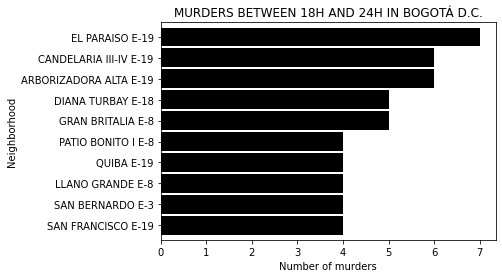

In [8]:
ax0 = neighborhoods_10.plot.barh(width = .9,color = "black",legend = False,title = "MURDERS BETWEEN 18H AND 24H IN BOGOTÁ D.C.")
ax0.set_yticklabels(np.array(neighborhoods_10["Neighborhood"]))
ax0.invert_yaxis()
ax0.set_ylabel("Neighborhood")
ax0.set_xlabel("Number of murders")

What other insights can you extract from this dataset?

It is important to notice that the murders occur not only between 6 afternoon and 12 mindnight, but in the earlymorning as well.


<ipython-input-9-4ed830ca5845>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Bog["Hour_Only"] = df_Bog["Hora"].dt.hour


Text(0.5, 0, 'Hour')

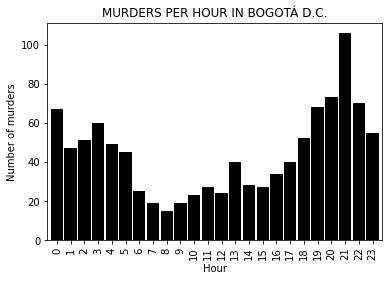

In [9]:
print("It is important to notice that the murders occur not only between 6 afternoon and 12 mindnight, but in the earlymorning as well.")

df_Bog["Hour_Only"] = df_Bog["Hora"].dt.hour
ax1 = df_Bog[["Hour_Only","Cantidad"]].groupby("Hour_Only").count().plot.bar(width = .9,color = "black" ,title = "MURDERS PER HOUR IN BOGOTÁ D.C.",legend = False)
ax1.set_ylabel("Number of murders")
ax1.set_xlabel("Hour")

# Would make sense a machine learning model for supporting the police force in its work? What kind of model would you choose (regression, classification, clustering)? Train one and evaluate its performance.

It would make sensto to use a machine learning model for supporting the police, however its is important to fin correlaions between the features to make this model


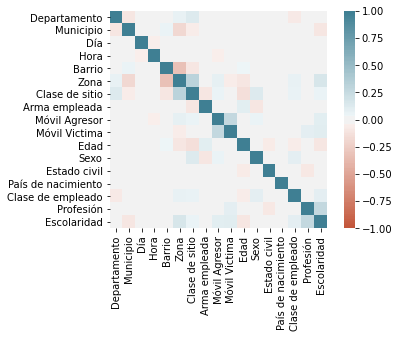

In [12]:
print("It would make sensto to use a machine learning model for supporting the police, however its is important to fin correlaions between the features to make this model")

df_Cat = pd.DataFrame()

for i in df.columns:
    if type(df[i].iloc[0]) == str:
        df_Cat[i] = df[i].astype('category').cat.codes
    else:
        df_Cat[i] = df[i].astype('category')
plt.figure()
fg1 = sns.heatmap(df_Cat.corr(),  vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20, 220, n=200),square=True)

It is possible to notice that this variables are no correlated, and the use of a machine learning model is not appopriate for now. To prove this there will be use the ML clustering algorithm K-means


<ipython-input-14-88faba101908>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Bog['Barrio'] = df_Bog['Barrio'].astype('category').cat.codes
<ipython-input-14-88faba101908>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Bog['Hour_Only'] = df_Bog['Hour_Only'].astype('category').cat.codes


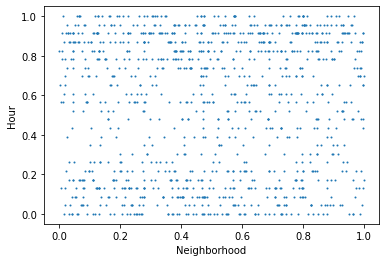

In [14]:
df_Bog['Barrio'] = df_Bog['Barrio'].astype('category').cat.codes
df_Bog['Hour_Only'] = df_Bog['Hour_Only'].astype('category').cat.codes
# df_Bog.plot.scatter(x = "Barrio",y = "Hour_Only")

df_K = df_Bog[["Barrio","Hour_Only"]]

min_max_scaler = preprocessing.MinMaxScaler() 
df_escalado = min_max_scaler.fit_transform(df_K)
df_escalado = pd.DataFrame(df_escalado)
df_escalado = df_escalado.rename(columns = {0: 'Neighborhood', 1: 'Hour'})

X = df_escalado['Neighborhood'].values
y = df_escalado['Hour'].values

plt.figure(0)
plt.plot(X,y,'o',markersize=1)
plt.xlabel('Neighborhood')
plt.ylabel('Hour')
plt.show()

This is the information that we want to cluster, hour or murder by neightborhood.

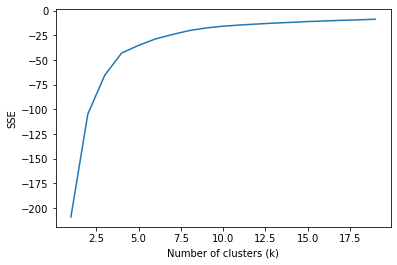

In [15]:
# Application of k-means

# Curva elbow para determinar valor óptimo de k.
nc = range(1, 20) # El número de iteraciones que queremos hacer.
kmeans = [KMeans(n_clusters=i) for i in nc]
score = [kmeans[i].fit(df_escalado).score(df_escalado) for i in range(len(kmeans))]

plt.figure(1)
plt.plot(nc,score)
plt.xlabel('Number of clusters (k)')
plt.ylabel('SSE')
plt.show()

The best number of clusters is between 3 and 5 clusters, however, this clustering has no sense for the neightborhoods, so we fit our model with 2 clusters.

[[0.49264185 0.18004085]
 [0.50109327 0.8137552 ]]


<ipython-input-16-5ea8b3e35b3a>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_K['label'] = labels


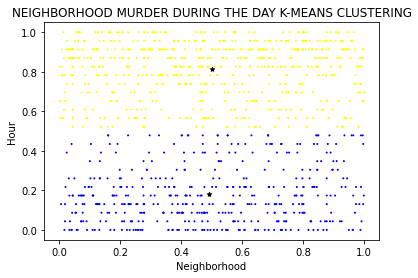

In [16]:
# Aplication of k-means with k = 2.
kmeans = KMeans(n_clusters=2).fit(df_escalado)
centroids = kmeans.cluster_centers_
print(centroids)

# Label DF
labels = kmeans.predict(df_escalado)
df_K['label'] = labels

# Plot k-means clustering.
colores=['blue','yellow']
asignar=[]
for row in labels:
     asignar.append(colores[row])
plt.figure(2)
plt.scatter(X, y, c=asignar, s=1)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='*', c='black', s=20) # Marco centroides.
plt.xlabel('Neighborhood')
plt.ylabel('Hour')
plt.title('NEIGHBORHOOD MURDER DURING THE DAY K-MEANS CLUSTERING')
plt.show()

# How would you deploy your model? Propose an architecture and explain it.

As observed previously, the clustering model wasn't very useful to predict the time of murders for certain neighborhoods however it would be useful to try to locate in each city and make a cluster based on the city map, hour of the murder and try to correlate more features of the dataset that might be usefull, like scholarity or profession. 

The reason why classification was not useful in this case, if we would have information of other chrimes, perhaps it would be easier to estimate a new feature as murder and no murder, like a classification problem. 